### Step1: Dataset Preparation

In [16]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from keras.preprocessing import image

In [17]:
p=Path("Train/Images")
print(type(p))

<class 'pathlib.PosixPath'>


In [18]:
image_data=[]
for img_path in p.glob("*.jpg"):
    img=image.load_img(img_path,target_size=(64,64))
    img_array=image.img_to_array(img)
    image_data.append(img_array)

/home/muskan/anaconda3/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [19]:
labels=[]
labels_dict={"Pikachu":0,"Bulbasaur":1,"Charmander":2}
labels_csv=pd.read_csv("Train/train.csv").values
print(labels_csv.shape)
for i in range(labels_csv.shape[0]):
    labels.append(labels_dict[labels_csv[i,1]])
print(labels[:5])    

(304, 2)
[0, 0, 0, 0, 0]


In [20]:
print(len(image_data),len(labels))

304 304


In [21]:
#Convert this data into numpy array
image_data=np.array(image_data,dtype='float32')/255.0
labels=np.array(labels)
print(image_data.shape,labels.shape)

(304, 64, 64, 3) (304,)


### Step2: Visualize this data

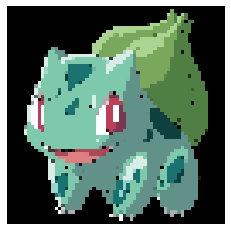

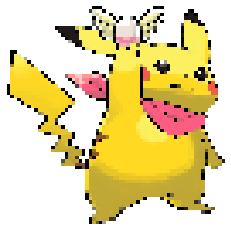

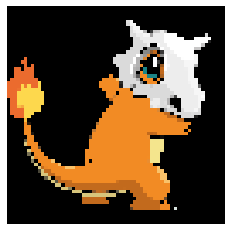

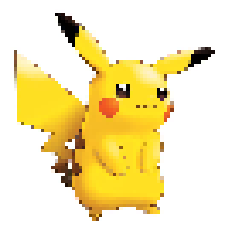

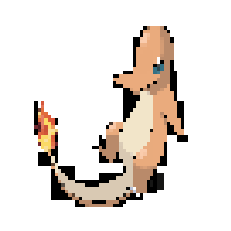

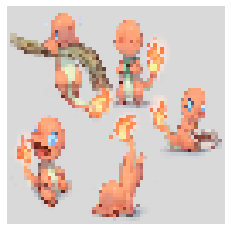

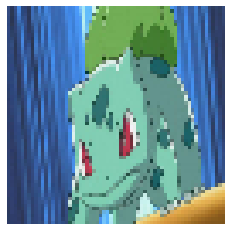

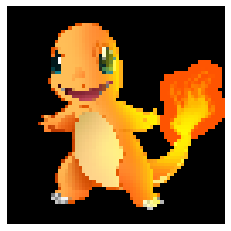

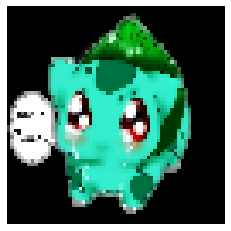

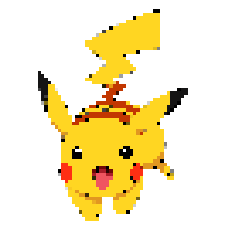

In [22]:
import matplotlib.pyplot as plt
def drawImg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return
    
for i in range(10):
    drawImg(image_data[i])    

### Step3: Randomly shuffle data

In [23]:
import random
#zip
combined=list(zip(image_data,labels))

random.shuffle(combined)

#unzip
image_data[:],labels[:]=zip(*combined)

### Step4: Make SVM classifier class

In [24]:
#Make a class that implements SVM
class SVM:
    def __init__(self,c=1.0):
        self.c=c
        self.w=0
        self.b=0
        
    def hingeLoss(self,W,bias,X,Y):
        loss=0.0
        loss+=0.5*np.dot(W,W.T)
        
        m=X.shape[0]
        for i in range(m):
            ti=Y[i]*(np.dot(W,X[i].T)+bias)
            loss+=self.c*max(0,1-ti)
            
        return loss[0][0]    
    
    def fit(self,X,Y,batch_size=100,learning_rate=0.001,max_itr=300):
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        
        n=learning_rate
        c=self.c
        
        #Init the model parameters
        W=np.zeros((1,no_of_features))
        bias=0
        
        #Initial loss
        print(self.hingeLoss(W,bias,X,Y)) 
        
        #Training from here... using Mini Batch Gradient Descent
        losses=[]
        
        #training loop
        for it in range(max_itr): 
            l=self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            
            #Shuffle
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                
                #assume 0 gradient for batch
                gradW=0
                gradb=0
                
                #interate over all examples in mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i=ids[j]
                        ti=Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>=1:
                            gradW+=0
                            gradb+=0
                            
                        else:
                            gradW+=c*Y[i]*X[i]
                            gradb+=c*Y[i]

                #Gradient of batch is ready-- Update W,b
                W = W - n*W + n*gradW
                bias = bias + n*gradb
                
        self.w=W
        self.b=bias
        return W,bias,losses
                            
        

### Step5: Convert data for one vs one classification

In [25]:
print(image_data.shape,labels.shape)
M = image_data.shape[0]
image_data=image_data.reshape((M,-1))
print(image_data.shape)

(304, 64, 64, 3) (304,)
(304, 12288)


In [26]:
CLASSES=len(np.unique(labels))
print(CLASSES)

3


In [27]:
def classWiseData(x,y):
    data={}
    
    for i in range(CLASSES):
        data[i]=[]
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k]=np.array(data[k])
        
    return data            

In [28]:
data=classWiseData(image_data,labels)
print(data[0].shape[0])
print(data[1].shape)

101
(101, 12288)


In [29]:
def getDataPairForSVM(d1,d2):
    l1,l2=d1.shape[0],d2.shape[0]
    samples=l1+l2
    features=d1.shape[1]
    
    data_pair=np.zeros((samples,features))
    data_labels=np.zeros((samples,))
    
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    data_labels[:l1]=-1
    data_labels[l1:]=1
    
    return data_pair,data_labels

##  Implementing one vs one scheme : Training nC2 SVM classifiers

202.0


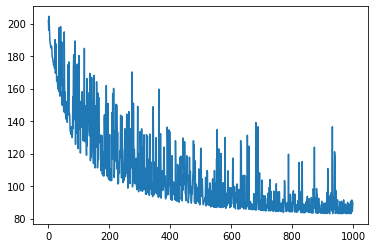

In [30]:
mySVM  = SVM()
xp, yp  = getDataPairForSVM(data[0],data[1])
w,b,loss  = mySVM.fit(xp,yp,learning_rate=0.00001,max_itr=1000)
#print(loss)
plt.plot(loss)

### Step6: Store weights of nC2 classifiers in 2D matrix

In [31]:
def trainSVMs(data):
    svm_classifiers={}
    
    for i in range(CLASSES):
        svm_classifiers[i]={}
        
        for j in range(i+1,CLASSES):
            xpair,ypair=getDataPairForSVM(data[i],data[j])
            mySVM=SVM()
            wts,b,loss=mySVM.fit(xpair,ypair,learning_rate=0.00001,max_itr=1000)
            plt.plot(loss,label="{},{}".format(i,j))
            plt.legend()
            plt.show()
            svm_classifiers[i][j]=(wts,b)
            
    return svm_classifiers        

202.0


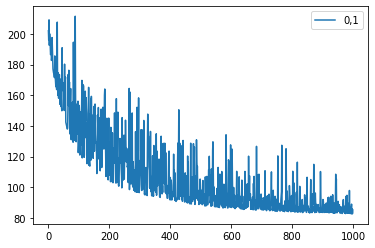

203.0


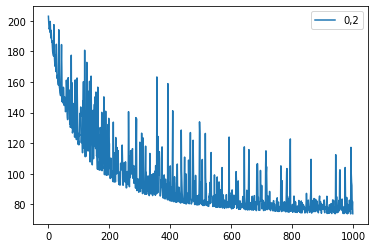

203.0


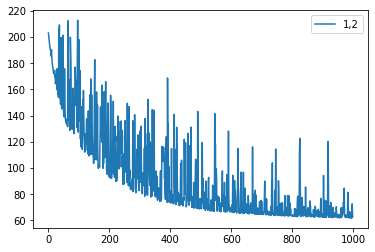

In [32]:
svm_classifiers=trainSVMs(data)

In [35]:
pika-balba=svm_classifiers[0][1]
print(pika-balba[0].shape)  #wts
print(pika-balba[1].shape)  #bias- a scaler
print(pika-balba)

SyntaxError: can't assign to operator (<ipython-input-35-673eff04d2dd>, line 1)

### Step7: Prediction

In [36]:
def binaryPredict(x,w,b):
    z=np.dot(x,w.T)+b
    if z>=0:
        return 1
    else:
        return -1
    
def predict(x):
    count=np.zeros((CLASSES,))
    
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b=svm_classifiers[i][j]
            z=binaryPredict(x,w,b)
            if z==1:
                count[j]+=1
            else:
                count[i]+=1
                
    final_prediction=np.argmax(count)
    return final_prediction

In [37]:
print(predict(image_data[0]))
print(labels[0])

1
1


### Step8: Calculate accuracy

In [38]:
def accuracy(x,y):
    count=0
    for i in range(x.shape[0]):
        prediction=predict(x[i])
        if prediction==y[i]:
            count+=1
    
    return count/x.shape[0]

In [39]:
accuracy(image_data,labels)

0.6776315789473685

### Check accuracy of sklearn svm

In [40]:
from sklearn import svm
svm_classifier=svm.SVC(kernel='linear',C=1.0)
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.694078947368421

In [47]:
p=Path("Test/Images")

In [48]:
test_image_id=[]
test_image_data=[]
for img_path in p.glob("*.jpg"):
    test_image_id.append(str(img_path).split('/')[-1])
    img=image.load_img(img_path,target_size=(64,64))
    img_array=image.img_to_array(img)
    test_image_data.append(img_array)

In [49]:
print(len(test_image_data))
print(test_image_id[:5])

123
['1122.jpg', '2206.jpg', '2008.jpg', '1108.jpg', '2011.jpg']


In [50]:
test_image_data=np.array(test_image_data,dtype='float32')/255.0

In [52]:
M = test_image_data.shape[0]
test_image_data=test_image_data.reshape((M,-1))

In [53]:
y_pred=[]
for i in range(test_image_data.shape[0]):
    y_pred.append(predict(test_image_data[i]))

In [54]:
print(y_pred)

[1, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]


In [55]:
test_image_dict={}
for i in range(len(test_image_id)):
    test_image_dict[test_image_id[i]]=i
print(test_image_dict)    

{'1122.jpg': 0, '2206.jpg': 1, '2008.jpg': 2, '1108.jpg': 3, '2011.jpg': 4, '2023.jpg': 5, '1127.jpg': 6, '2216.jpg': 7, '2000.jpg': 8, '2233.jpg': 9, '1123.jpg': 10, '2030.jpg': 11, '2226.jpg': 12, '1124.jpg': 13, '1139.jpg': 14, '2222.jpg': 15, '1128.jpg': 16, '2214.jpg': 17, '1107.jpg': 18, '2219.jpg': 19, '2211.jpg': 20, '2033.jpg': 21, '2225.jpg': 22, '1101.jpg': 23, '2215.jpg': 24, '1126.jpg': 25, '2240.jpg': 26, '2026.jpg': 27, '1103.jpg': 28, '2005.jpg': 29, '2200.jpg': 30, '2004.jpg': 31, '2018.jpg': 32, '2220.jpg': 33, '1135.jpg': 34, '1118.jpg': 35, '2021.jpg': 36, '2014.jpg': 37, '2231.jpg': 38, '2001.jpg': 39, '1110.jpg': 40, '2002.jpg': 41, '2239.jpg': 42, '1100.jpg': 43, '2031.jpg': 44, '2027.jpg': 45, '2235.jpg': 46, '2234.jpg': 47, '2028.jpg': 48, '1119.jpg': 49, '2012.jpg': 50, '1132.jpg': 51, '2236.jpg': 52, '2227.jpg': 53, '2207.jpg': 54, '2016.jpg': 55, '1137.jpg': 56, '1140.jpg': 57, '2035.jpg': 58, '2015.jpg': 59, '2020.jpg': 60, '2022.jpg': 61, '2209.jpg': 62, '

In [56]:
df=pd.read_csv("Test/test.csv")
test_id=df.values
print(test_id.shape)

(123, 1)


In [63]:
pred_labels=[]
labels_dict={0:"Pikachu",1:"Bulbasaur",2:"Charmander"}
for i in range(test_id.shape[0]):
    index=test_image_dict[test_id[i,0]]
    pred_labels.append(labels_dict[y_pred[index]])

In [65]:
print(pred_labels[:5])

['Bulbasaur', 'Pikachu', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur']


In [66]:
df['NameOfPokemon']=pred_labels

In [67]:
print(df.head())

    ImageId NameOfPokemon
0  1106.jpg     Bulbasaur
1  2236.jpg       Pikachu
2  1131.jpg     Bulbasaur
3  2221.jpg     Bulbasaur
4  2011.jpg     Bulbasaur


In [68]:
df.to_csv('submit.csv',index=False)